In [1]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [3]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data

dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing data

In [4]:
dftrain.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [5]:
dftrain.isnull().sum().sum()

0

In [6]:
dfeval.isnull().sum().sum()

0

In [7]:
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [8]:
y_train

0      0
1      1
2      1
3      1
4      0
      ..
622    0
623    0
624    1
625    0
626    0
Name: survived, Length: 627, dtype: int64

In [9]:
y_eval

0      0
1      0
2      1
3      1
4      1
      ..
259    1
260    0
261    0
262    0
263    1
Name: survived, Length: 264, dtype: int64

In [10]:
dftrain.loc[2]

sex                        female
age                            26
n_siblings_spouses              0
parch                           0
fare                        7.925
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 2, dtype: object

In [11]:
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [12]:
print(dftrain.loc[2], y_train[2])

sex                        female
age                            26
n_siblings_spouses              0
parch                           0
fare                        7.925
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 2, dtype: object 1


Text(0.5, 0, '% survive')

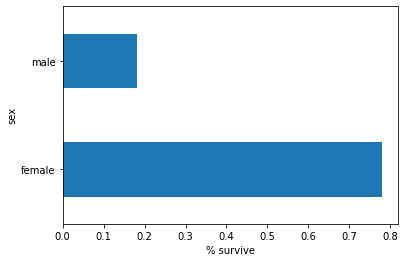

In [13]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [14]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.value_counts()

sex     survived
female  1           169
        0            48
male    0           336
        1            74
Name: survived, dtype: int64

In [15]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [16]:
dftrain.select_dtypes(include=[int,float])

,age,n_siblings_spouses,parch,fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,28.0,0,0,8.4583
...,...,...,...,...
622,28.0,0,0,10.5000
623,25.0,0,0,7.0500
624,19.0,0,0,30.0000
625,28.0,1,2,23.4500


In [17]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.dtypes.float32, ))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

In [18]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dftrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [19]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqac1tx2e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [20]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.75


In [21]:
predict = list(linear_est.predict(eval_input_fn))
print(y_eval[4])
print(predict[4]['probabilities'][1])

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpqac1tx2e/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1
0.339789


In [22]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [23]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

16384/573 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [24]:
train

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0
...,...,...,...,...,...
115,5.5,2.6,4.4,1.2,1
116,5.7,3.0,4.2,1.2,1
117,4.4,2.9,1.4,0.2,0
118,4.8,3.0,1.4,0.1,0


In [25]:
test

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.9,3.0,4.2,1.5,1
1,6.9,3.1,5.4,2.1,2
2,5.1,3.3,1.7,0.5,0
3,6.0,3.4,4.5,1.6,1
4,5.5,2.5,4.0,1.3,1
5,6.2,2.9,4.3,1.3,1
6,5.5,4.2,1.4,0.2,0
7,6.3,2.8,5.1,1.5,2
8,5.6,3.0,4.1,1.3,1
9,6.7,2.5,5.8,1.8,2


In [26]:
train_y = train.pop('Species')
test_y = test.pop('Species')

In [27]:
train_y

0      2
1      1
2      2
3      0
4      0
      ..
115    1
116    1
117    0
118    0
119    1
Name: Species, Length: 120, dtype: int64

In [28]:
test_y

0     1
1     2
2     0
3     1
4     1
5     1
6     0
7     2
8     1
9     2
10    2
11    0
12    2
13    1
14    1
15    0
16    1
17    0
18    0
19    2
20    0
21    1
22    2
23    1
24    1
25    1
26    0
27    1
28    2
29    1
Name: Species, dtype: int64

In [29]:
def input_function1(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        dataset = dataset.shuffle(1000).repeat()
    
    return dataset.batch(batch_size)

In [30]:
# Feature columns describe how to use the input.
my_feature_columns = []
for key in train.keys():
    my_feature_columns.append(tf.feature_column.numeric_column(key=key))
print(my_feature_columns)

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [31]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbwn3fzo3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
classifier.train(input_fn = lambda : input_function1(train, train_y, training = True), steps = 5000)
# We include a lambda to avoid creating an inner function previously

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpbwn3fzo3/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.2097852, step = 0
INFO:tensorflow:global_step/sec: 418.13
INFO:tensorflow:loss = 1.0519531, step = 100 (0.244 sec)
INFO:tensorflow:global_step/sec: 479.851
INFO:tensorflow:loss = 1.0356319, step = 200 (0.205 sec)
INFO:tensorflow:global_step/sec: 496.967
INFO:tensorflow:loss = 0.98983896, step = 300 (0.205 sec)
INFO:tensorflow:global_step/sec: 499.488
INFO:tensorflow:loss = 0.96273077, step = 400 (0.202 sec)
INFO:tensorflow:global_step/sec: 479.016
INFO:tensorflow:loss = 0.93085897, step = 500 (0.206 sec)
INFO

In [33]:
result_eval = classifier.evaluate(input_fn = lambda : input_function1(test, test_y, training = False))
result_eval['accuracy']

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-09-13T23:26:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbwn3fzo3/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.22529s
INFO:tensorflow:Finished evaluation at 2021-09-13-23:26:22
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.8666667, average_loss = 0.50801647, global_step = 5000, loss = 0.50801647
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /tmp/tmpbwn3fzo3/model.ckpt-5000


0.8666667

In [34]:
result_predict = list(classifier.predict(input_fn = lambda : input_function1(test, test_y, training = False)))
print(test_y[2])
print(result_predict[2]['probabilities'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbwn3fzo3/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0
[0.7668243  0.16397373 0.06920195]


In [35]:
result_predict

[{'all_class_ids': array([0, 1, 2], dtype=int32),
  'all_classes': array([b'0', b'1', b'2'], dtype=object),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'logits': array([-2.0070262 , -0.18056951, -0.21138975], dtype=float32),
  'probabilities': array([0.07555641, 0.4693441 , 0.45509943], dtype=float32)},
 {'all_class_ids': array([0, 1, 2], dtype=int32),
  'all_classes': array([b'0', b'1', b'2'], dtype=object),
  'class_ids': array([2]),
  'classes': array([b'2'], dtype=object),
  'logits': array([-3.1416733 , -0.28813696,  0.2875429 ], dtype=float32),
  'probabilities': array([0.0203246 , 0.35261187, 0.6270635 ], dtype=float32)},
 {'all_class_ids': array([0, 1, 2], dtype=int32),
  'all_classes': array([b'0', b'1', b'2'], dtype=object),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'logits': array([ 0.5460025 , -0.99654895, -1.859226  ], dtype=float32),
  'probabilities': array([0.7668243 , 0.16397373, 0.06920195], dtype=float32)},
 {'a

In [36]:
# def add(a,b):
#   return a+b

# x = lambda : add(2,3)
# type(x)
# y = input('type')
# print(y)

In [37]:
def input_function2(features, batch_size=256):
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features:
  valid = True
  while valid: 
    val = input(feature + ": ")
    if not val.isdigit(): valid = False

  predict[feature] = [float(val)]
  
print(predict)

predictions = classifier.predict(input_fn=lambda: input_function2(predict))
print(predictions)
for pred_dict in predictions:
  print(pred_dict)
  class_id = pred_dict['class_ids'][0]
  print(class_id)
  probability = pred_dict['probabilities'][class_id]
  print(probability)
  print('prediction is {} ({}%)'.format(SPECIES[class_id], probability*100))

Please type numeric values as prompted.
SepalLength: 1.2
SepalWidth: 2.4
PetalLength: 5.6
PetalWidth: 6.2
{'SepalLength': [1.2], 'SepalWidth': [2.4], 'PetalLength': [5.6], 'PetalWidth': [6.2]}
<generator object Estimator.predict at 0x7fe53a7aa9d0>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbwn3fzo3/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-5.7029204 , -1.0606498 ,  0.86650044], dtype=float32), 'probabilities': array([0.00122289, 0.12691095, 0.87186617], dtype=float32), 'class_ids': array([2]), 'classes': array([b'2'], dtype=object), 'all_class_ids': array([0, 1, 2], dtype=int32), 'all_classes': array([b'0', b'1', b'2'], dtype=object)}
2
0.87186617
prediction is Virginica (87.18661665916443%)


In [38]:
import tensorflow_probability as tfp  # We are using a different module from tensorflow this time

In [39]:
tfd = tfp.distributions  # making a shortcut for later on
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])  # Refer to point 2 above
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])  # refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])  # refer to point 5 above

# the loc argument represents the mean and the scale is the standard devitation

In [40]:
model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

In [46]:
mean = model.mean()
tf.print(mean)
print(mean)
mean
# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
# with tf.compat.v1.Session() as sess:  
#   print(mean.numpy())

[2.99999976 5.99999952 7.49999952 ... 8.62500095 8.81250095 8.90625]
tf.Tensor([2.9999998 5.9999995 7.4999995 8.25      8.625001  8.812501  8.90625  ], shape=(7,), dtype=float32)


<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([2.9999998, 5.9999995, 7.4999995, 8.25     , 8.625001 , 8.812501 ,
       8.90625  ], dtype=float32)>

In [48]:
model

<tfp.distributions.HiddenMarkovModel 'HiddenMarkovModel' batch_shape=[] event_shape=[7] dtype=float32>